In [1]:
import urllib.request
import random
import re
import string
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd

import nltk as nl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from warnings import filterwarnings
filterwarnings('ignore')
nl.download('stopwords')
nl.download('wordnet')
nl.download('punkt')
nl.download('omw-1.4')
stop_words=set(stopwords.words("english"))

from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import gensim.corpora as corpora
import gensim
import pyLDAvis

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize, LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

[nltk_data] Downloading package stopwords to /home/ahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ahmed/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/home/ahmed/anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
books= [["https://www.gutenberg.org/files/1342/1342-0.txt","Jane Austen"],
        ["https://www.gutenberg.org/files/52766/52766-0.txt","Charles K.Adams "],
        ["https://www.gutenberg.org/files/67104/67104-0.txt","Bertrand Russel"],
        ["https://www.gutenberg.org/files/4280/4280-0.txt","Immanuel Kant"],
        ["https://www.gutenberg.org/cache/epub/20195/pg20195.txt","F. Morley Fletcher"]
       ]

In [3]:
def get_books_before_filter(books:list) -> list:
    '''
        returns a list of strings, where every string is the book's content.
    '''
    lst_books_txt = []
    for link in books:
        with urllib.request.urlopen(link[0]) as book_file:
            raw = book_file.read().decode('utf-8')
            lst_books_txt.append(raw)
    return lst_books_txt

#l = get_books_before_filter(books)

In [4]:
def get_books(books_links:list) -> list:
    book_list= []
    for book in get_books_before_filter(books_links):
        splited_book = re.split(r"\r\n",book)
        good_paragraphs = [paragraph for paragraph in splited_book if len(paragraph)>=60]
        book_list.append(" ".join(good_paragraphs))
    return book_list
#ls = get_books(books)


In [5]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [6]:
def remove_gutenberg_annotations():
    pass

def lemmitization():
    pass

In [7]:
def cleanUp(lstTxt: list) -> list:
    
    '''
        1- CleanUp.
            1.1 include numbers and alphabets only.
            1.2 Change Case to lower case.
            1.3 Remove extra spaces.
            1.4 remove leading whitespaces.
            1.5 Replace punctuation with whitespaces
    '''
    cleaned_lst = []
    for txt in lstTxt:
        txt = re.sub(r'[^A-Z a-z]', ' ', txt)# include only alphabets and numbers
        txt = re.sub(' +', ' ', txt)# remove extra spaces
        txt = txt.lower()#convert to lower case
        txt = txt.strip()# remove leading whitespaces
        txt = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', txt) #Replace punctuation with whitespaces
        cleaned_lst.append(txt)
    return cleaned_lst


In [8]:
def stopWordRemoval(book_lst: list) -> list:
    l = []
    for book in book_lst:
        words = word_tokenize(book)
        good_tokens = []
        for word in words:
            if word not in stop_words:
                if word not in ['project' ,'gutenberg', 'ebook' ]:
                    good_tokens.append(word)
        l.append(" ".join(good_tokens))
    return l

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
 
lemmatizer = WordNetLemmatizer()
def applay_lemmatization2(df):
    new_df = []
    wnl = WordNetLemmatizer()
    for i in range(len(df)):
        pos_tagged = nltk.pos_tag(nltk.word_tokenize(df['Text'][i]))
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:       
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        new_df.append( " ".join(lemmatized_sentence))

    return new_df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ahmed/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
def partitioning(txt:str) -> list:
    
    '''
        This function tries to partition a string into 200 partitions with 150 words for each partition.
        The function expexcts a string and returns a list of strings (where string length is 100) of size 200
        (number of partitions). 
    '''
    
    try:
        
        res = [] # where the result will be
        beg = 0 # an index for the beginning of the partition
        end = 150# an end for the last index we seek
        lst_txt = re.split(' ', txt)
        for i in range(200):
            res.append(' '.join(lst_txt[beg:end]))
            beg = end
            end += 150
           
        return res
    
    except TypeError:
        print("Please specifiy a string as an argument")

In [11]:
labels=['A', 'B', 'C', 'D', 'E']
def MakeDatafram(lst:list, index:int) -> pd.DataFrame:
    
    '''
        The function consumes a list which is the list of text srings of the book and also an integer which is
        the index of the book in the all list of books and produces a dataframe that maps the lst 
        and the index together into two columns.
        
    '''
    df = pd.DataFrame({'Text': lst,'label':[labels[index]]*200})
    return df

In [12]:
def StackDataFrames(lst:list) -> pd.DataFrame:
    return pd.concat(lst,ignore_index=True)

In [13]:
def prepare(books: list) -> pd.DataFrame:
    '''
        1- select 200 random sample of each book, each record is 100 words.
        2- Label them.
        3- return a DataFrame of all the labeled data.
    '''
    i = 0
    lst_dfs = []
    
    for book in books:
        partition = partitioning(book)
        df = MakeDatafram(partition, i)
        lst_dfs.append(df)
        i += 1
    return StackDataFrames(lst_dfs)

In [14]:
def pre_processing(books: list) -> pd.DataFrame:
    '''
        Aggregate all the preprocessing tasks in one place.
    '''
    cleaned = cleanUp(books)
    without_stop = stopWordRemoval(cleaned)
    
    return prepare(without_stop)


In [15]:
df = pre_processing(get_books(books))
df.shape

(1000, 2)

In [16]:
df['Text'] = applay_lemmatization2(df)

In [17]:
df.head()

,Text,label
0,pride prejudice jane austen use anyone anywher...,A
1,talk likely may fall love one therefore see oc...,A
2,twenty mr bennet odd mixture quick part sarcas...,A
3,one know man really end fortnight venture some...,A
4,young dare say mr bingley dance next ball oh s...,A


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y_encoded = df.iloc[:, 1]
y=labelencoder_y.fit_transform(y_encoded)
print(y.shape)

(1000,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0], y, random_state=42)

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)


In [20]:
def BOW(df):
    all_Partitions = list(df["Text"])
    
    vectorizer = CountVectorizer(analyzer = "word")
    bow_matrix = vectorizer.fit(all_Partitions)
    feature_names = vectorizer.vocabulary_
    
    bow_matrix = vectorizer.transform(all_Partitions)
    feature_array = bow_matrix.toarray()
    
    #display(pd.DataFrame(feature_array, columns=feature_names))
    #return pd.DataFrame(feature_array, columns=feature_names)
    return feature_array

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
def TF_IDF(X_train, X_test):
    vectorizer = TfidfVectorizer()
    X_tf_idf = vectorizer.fit_transform(X_train['Text'])
    X_test_tf_idf = vectorizer.fit_transform(X_test['Text'])
    return X_tf_idf, X_test_tf_idf

In [22]:
def Transform(X, transformer = 'BOW'):
    if transformer == "BOW":
        return BOW(X)
    elif transformer == "TF-IDF":
        return TF_IDF(X, X_test)
    elif transformer == "LDA":
        pass

In [23]:
from sklearn.cluster import KMeans
def K_means(X):
    model_km = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
    model_km.fit(X)
    y_km = model_km.fit_predict(X)
    return model_km, y_km

In [24]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [25]:
from sklearn.cluster import AgglomerativeClustering
def Agglomorative(X):
    model_agg = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean',
                                        linkage = 'ward', compute_distances=True)
    y_agg_bow = model_agg.fit_predict(X)
    return model_agg, y_agg_bow

In [26]:
def Train(X, algo='k_mean'):
    if algo == 'k_mean':
        return K_means(X)
    elif algo == 'EM':
        return EM()
    elif algo == 'Agg':
        return Agglomorative(X)

In [27]:
from sklearn.decomposition import TruncatedSVD
from copy import deepcopy

def dim_reduction(X, model, centers=0):
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    
    components = svd.fit_transform(X)
    components_df = pd.DataFrame(data = components,
                columns = ['bow component 1', 'bow component 2'])
    if type(centers) == type(0):
        centers = svd.transform(model.cluster_centers_)
    centers_new = deepcopy(centers)
    return centers_new, components_df, components

In [28]:
import matplotlib.pyplot as plt
colors = ['b', 'y','r', 'g', 'c']
authors = ['a', 'b', 'c', 'd', 'e']

def visualizeClusters(components, y_train, centers):
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlabel('1st Component', fontsize = 12)
    ax.set_ylabel('2nd Component', fontsize = 12)
    ax.set_title('Clusters visualization', fontsize = 18)
    
    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4],authors):
        ax.scatter(components[y_train.iloc[:, 0] == i, 0],
                   components[y_train.iloc[:, 0] == i, 1],
                   alpha=.8, color=color, label=target_name, s = 20)
        #print(y_train.iloc[:, 0] == i)
        
    ax.legend(loc='best', shadow=False, scatterpoints=1)
    #ax.scatter(centers[:,0], centers[:,1], marker='*', c='k',
               #label = 'centroid', s=350)

In [29]:
import scipy.cluster.hierarchy as sch
def visualizeHierarchy(X, y):
    plt.xlim(-15,15)
    plt.ylim(-15,15)

    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

    plt.scatter(X[y ==0,0], X[y == 0,1], s=100, c='red')
    plt.scatter(X[y ==1,0], X[y == 1,1], s=100, c='yellow')
    plt.scatter(X[y ==2,0], X[y == 2,1], s=100, c='blue')
    plt.scatter(X[y ==3,0], X[y == 3,1], s=100, c='cyan')
    plt.scatter(X[y ==4,0], X[y == 4,1], s=100, c='green')

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score

def Evaluate(y_actual, y_prediction):
    kappa = cohen_kappa_score(y_actual, y_prediction)
    sil = silhouette_score(y_actual, y_prediction)
    indices = ['kappa', 'silhouette']
    return pd.DataFrame(data=[kappa, sil], index=indices, columns=['values'])

## Transformation / Feature Engineering:  semantics as numbers

# 1. BOW

In [31]:
X_bow = Transform(X_train, transformer="BOW")
X_bow.shape

(750, 8384)

## K-means with BOW

In [32]:
model_km_bow, y_km_bow = Train(X_bow, algo="k_mean")
model_km_bow.cluster_centers_.shape

(5, 8384)

In [33]:
Bow_center, Bow_components_df, Bow_components  = dim_reduction(X_bow, model_km_bow)

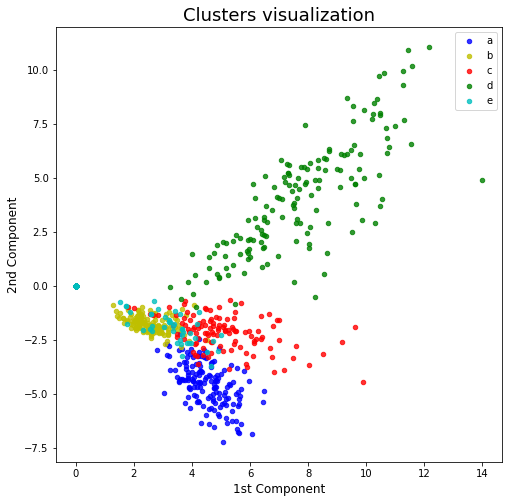

In [34]:
visualizeClusters(Bow_components, y_train, Bow_center)

## Evaluation of K-means with BOW


In [35]:
km_bow_eval = Evaluate(y_train, y_km_bow)
km_bow_eval

,values
kappa,-0.171596
silhouette,0.072979


## Agglomorative Clustering with BOW

In [36]:
model_agg_bow, y_agg_bow = Train(X_bow, algo="Agg")

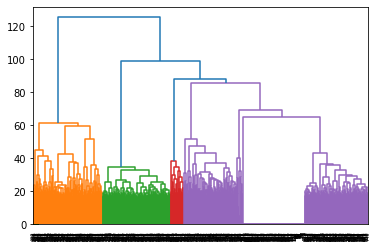

In [37]:
visualizeHierarchy(X_bow, y_agg_bow)

## Evaluation of Agglomorative with BOW

In [38]:
agg_bow_eval = Evaluate(y_train, y_agg_bow)
agg_bow_eval

,values
kappa,-0.243317
silhouette,0.335409


## EM Clustering with BOW

In [39]:
from sklearn import mixture
gaus_bow = mixture.GaussianMixture(n_components = 5, covariance_type = 'spherical'
                                      , max_iter=60)
gaus_bow.fit(X_bow)
X_bow.shape

(750, 8384)

In [40]:
svd_bow = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    
components = svd_bow.fit_transform(X_bow)

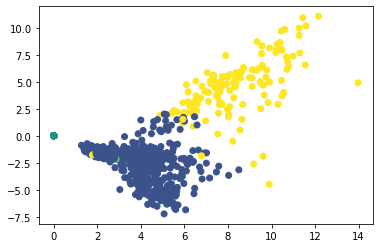

In [41]:
y_em_bow = gaus_bow.fit_predict(X_bow)
plt.scatter(components[:, 0], components[:, 1], c=y_em_bow, cmap='viridis');

## Evaluation of EM with BOW

In [42]:
y_em_bow = gaus_bow.fit_predict(X_bow)
em_bow_eval = Evaluate(y_train, y_em_bow)
em_bow_eval

,values
kappa,-0.195287
silhouette,0.199598


# 2. TF-IDF

In [43]:
X_train_tf_idf, X_test_tf_idf = Transform(X_train, transformer='TF-IDF')

In [44]:
X_train_tf_idf.shape

(750, 8384)

###  TF-IDF with KMeans

In [45]:
model_km_tf_idf, y_pred_tf_idf = Train(X_train_tf_idf, algo="k_mean")

In [46]:
tf_center, tf_components_df, tf_components  = dim_reduction(X_train_tf_idf, model_km_tf_idf)

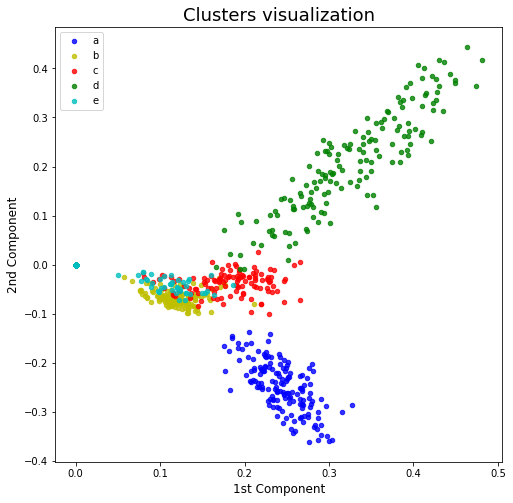

In [47]:
visualizeClusters(tf_components, y_train, tf_center)

## Evaluation of TF-IDF with K-means

In [48]:
km_tf_eval = Evaluate(y_train, y_pred_tf_idf)
km_tf_eval

,values
kappa,0.389900
silhouette,0.360056


## TF-IDF with AGGlomerative Clustering

In [49]:
model_agg_tf, y_agg_tf = Train(X_train_tf_idf.toarray(), algo="Agg")

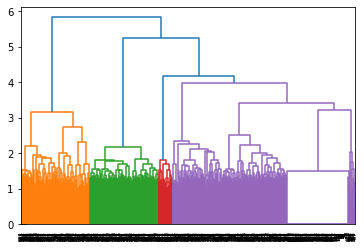

In [50]:
visualizeHierarchy(X_train_tf_idf.toarray(), y_agg_tf)

## Evaluation of TF-IDF with Agglomerative

In [51]:
agg_tf_eval = Evaluate(y_train, y_agg_tf)
agg_tf_eval

,values
kappa,-0.250086
silhouette,0.335061


## TF-IDF with EM

In [52]:
from sklearn import mixture
gaus_tf = mixture.GaussianMixture(n_components = 5, covariance_type = 'spherical'
                                      , max_iter=60)
gaus_tf.fit(X_train_tf_idf.toarray())

GaussianMixture(covariance_type='spherical', max_iter=60, n_components=5)

In [53]:
svd_tf = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    
components = svd_tf.fit_transform(X_bow)

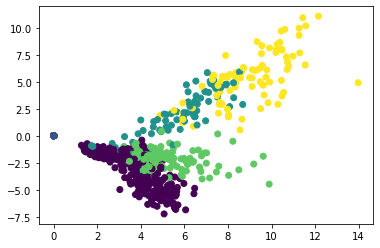

In [54]:
y_em_tf = gaus_tf.fit_predict(X_train_tf_idf.toarray())
plt.scatter(components[:, 0], components[:, 1], c=y_em_tf, cmap='viridis');

In [55]:
em_tf_eval = Evaluate(y_train, y_em_tf)
em_tf_eval

,values
kappa,0.018478
silhouette,0.286806


# 3. LDA

In [56]:
def doc_relation_rate(lda_top , num):
    print("Doc ",num,": ")
    for i,topic in enumerate(lda_top[num]):
        print("Author ",i+1,": ",topic*100,"%")

In [57]:
def topic_Modeling():
    vocab = vectorizer.get_feature_names()

    for i, comp in enumerate(lda_model.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
        print("Author "+str(i+1)+": ")
        for t in sorted_words:
            print(t[0],end=" ")
        print("\n")

In [58]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

train_vectorized = vectorizer.fit_transform(X_train['Text'])

In [59]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation( 
                                      n_components=5, max_iter=10, learning_method='online',   
                                      random_state=100, batch_size=128,            
                                      evaluate_every = -1, n_jobs = -1,)
lda_output = lda_model.fit_transform(train_vectorized)

print(lda_model) 

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=100)


In [60]:
doc_relation_rate(lda_output,300)

Doc  300 : 
Author  1 :  0.17005379061107312 %
Author  2 :  0.16811843814328659 %
Author  3 :  0.17098387201793525 %
Author  4 :  0.17349744343562157 %
Author  5 :  99.31734645579209 %


In [61]:
topic_Modeling()

Author 1: 
conception object time intuition priori pure representation cognition experience understand mean phenomenon empirical principle space possible thing reason unity relation 

Author 2: 
smuggle stuyvesant schuylkill nicolls inflame almanacs madness prying dispense warehouse transaction dwelling stamped overpower eloquence townsman disagreeable instantly deny newcastle 

Author 3: 
new time make body distance colony great force state light event general point washington british say earth observer law american 

Author 4: 
print block colour use cut key work line paper printing design wood make japanese form knife impression paste plate sheet 

Author 5: 
say elizabeth darcy bingley miss think jane bennet make sister know lady work collins young time great good soon wish 



### GridSearch for our LDA

In [ ]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [5], 'learning_decay': [.5, .7, .9]}
model = GridSearchCV(lda_model, param_grid=search_params)
model.fit(train_vectorized)

In [ ]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=5, n_jobs=1,perp_tol=0.1,
             random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0), n_jobs=1,
       param_grid={'n_topics': [4], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)

print("Best Log Likelihood Score: ", model.best_score_)

print("Model Perplexity: ", best_lda_model.perplexity(train_vectorized))

## some topic modeling and investigation

In [ ]:
lda_output = best_lda_model.transform(train_vectorized)
topicnames = ["Author" + str(i+1) for i in range(best_lda_model.n_components)]
docnames = ["Doc" + str(i+1) for i in range(len(X_train['Text']))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_Author'] = dominant_topic


def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [ ]:
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
df_topic_keywords.head()

In [ ]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

## LDA with K-means

In [ ]:
lda_output.shape, train_vectorized.shape

In [ ]:
from sklearn.cluster import KMeans
model_km_lda = KMeans(n_clusters=5)
model_km_lda.fit(train_vectorized)
y_km_lda = model_km_bow.fit_predict(train_vectorized)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from copy import deepcopy
lda_SVD = TruncatedSVD(n_components=2, random_state=42)
lda_Components = lda_SVD.fit_transform(train_vectorized)
lda_centers = lda_SVD.transform(model_km_lda.cluster_centers_)

centers_lda = deepcopy(lda_Components)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('lda Component 1', fontsize = 10)
ax.set_ylabel('lda Component 2', fontsize = 10)
ax.set_title('2lda component PCA', fontsize = 15)

colors = ['b', 'y','r', 'g', 'c']  
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4],['a', 'b', 'c', 'd','e']):
    ax.scatter(lda_Components[y_train.iloc[:,0] == i, 0], lda_Components[y_train.iloc[:,0] == i, 1],
               alpha=.8, color=color, label=target_name, s = 10)

In [ ]:
km_lda_eval = Evaluate(y_train, y_km_lda)
km_lda_eval

## LDA with EM

In [ ]:
n_components = np.arange(1, 6)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=42).fit(lda_output)
          for n in n_components]

In [ ]:
plt.plot(n_components, [m.bic(lda_output) for m in models], label='BIC')
plt.plot(n_components, [m.aic(lda_output) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
gmm = mixture.GaussianMixture(n_components=5)
gmm.fit(lda_output)

labels = gmm.predict(lda_output)
plt.scatter(lda_Components[:, 0], lda_Components[:, 1], c=labels, cmap='viridis');

In [ ]:
em_lda_eval = Evaluate(y_train, labels)
em_lda_eval

## LDA with Aglomerative clustering

In [ ]:
model_lda_agg, pred_lda_agg = Train(lda_output, algo='Agg')

In [ ]:
visualizeHierarchy(lda_output, pred_lda_agg)

In [ ]:
agg_lda_eval = Evaluate(y_train, pred_lda_agg)
agg_lda_eval

### LDA with gensim

In [ ]:
def towords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

In [ ]:
data_words = list(towords(df['Text']))

In [ ]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]#TF

In [ ]:
def LDA_Model(corpus,id2word):
    num_topics = 5
    # Build LDA model
    lda = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=5,random_state=12345,chunksize=100,per_word_topics=True)
    pprint(lda.print_topics())
    doc_lda = lda[corpus]
    return lda

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(LDA_Model(corpus,id2word), corpus, id2word)
LDAvis_prepared

# Best model

In [ ]:
t = km_bow_eval, em_bow_eval, agg_bow_eval, km_tf_eval, em_tf_eval, agg_tf_eval, km_lda_eval, em_lda_eval, agg_lda_eval
cols = ['BOW + kmean', 'BOW + EM', 'BOW + Agg', 'TF-IDF + Kmean', 'TF-IDF + EM',
        'TF-IDF + Agg', 'LDA + Kmean', 'LDA + EM', 'LDA + Agg']
l = pd.DataFrame()
l= pd.concat(t, axis=1)
l.columns = cols
l

In [ ]:
from sklearn.metrics import adjusted_rand_score as ars
all_ys = [y_km_bow, y_em_bow, y_agg_bow, y_pred_tf_idf, y_em_tf, y_agg_tf, y_km_lda, labels, pred_lda_agg]

all_rand_scores = []
for item in all_ys:
    all_rand_scores.append(ars(np.array(y_train).reshape(750,), item))

plt.bar([i for i in range(9)], all_rand_scores)
plt.xticks([i for i in range(9)], cols, rotation=90)
plt.ylabel("rand_Score")
plt.title('Rand_Score for all models')
plt.show()

# Error Analysis: a closer investigation

Let us visualize the BOW+K-means model to see again where are the clusters that overlap

In [ ]:
visualizeClusters(Bow_components, y_train, Bow_center)

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def text_of_partition(X, y, j):
    text = ''
    for i in range(X.shape[0]):
        if y.iloc[i, 0] == j:
            text += X.iloc[i,0]
    return text
text1 = text_of_partition(X_train,y_train, 0)
text2 = text_of_partition(X_train,y_train, 1)
text3 = text_of_partition(X_train,y_train, 2)
text4 = text_of_partition(X_train,y_train, 3)
text5 = text_of_partition(X_train,y_train, 4)


In [ ]:
wordcloud1 = WordCloud().generate(text1)
wordcloud2 = WordCloud().generate(text2)
wordcloud3 = WordCloud().generate(text3)
wordcloud4 = WordCloud().generate(text4)
wordcloud5 = WordCloud().generate(text5)
wordclouds = [wordcloud1, wordcloud2, wordcloud3, wordcloud4, wordcloud5]


In [ ]:
import matplotlib as mpl
fig = plt.figure(figsize=(10, 8))
spec = mpl.gridspec.GridSpec(ncols=6, nrows=2) # 6 columns evenly divides both 2 & 3

ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[0,4:])
ax4 = fig.add_subplot(spec[1,1:3]) # row 0 with axes spanning 2 cols on odds
ax5 = fig.add_subplot(spec[1,3:5])
ax1.imshow(wordclouds[0])
ax2.imshow(wordclouds[1])
ax3.imshow(wordclouds[2])
ax4.imshow(wordclouds[3])
ax5.imshow(wordclouds[4])


#### Our model makes most of its mistakes on the following clsuters
1. Clsuter 2.
2. Cluster 5.

In [ ]:
plt.subplot()
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
plt.subplot()
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis("off")
plt.show()